In [1]:
!pip install datasets

In [2]:
import os
import json
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

TRAIN_DIR = "/kaggle/working/plan_b_train_data"
TARGET_SIZE = 1024  # Upscale target for SSD-1B
os.makedirs(TRAIN_DIR, exist_ok=True)

# 1. Download directly from Hugging Face
print("Downloading pixel-art-nouns-2k from Hugging Face...")
dataset = load_dataset("jiovine/pixel-art-nouns-2k", split="train")

metadata = []
print(f"Upscaling {len(dataset)} images using Nearest Neighbor...")

for i, item in enumerate(tqdm(dataset)):
    try:
        # HF datasets automatically load images as PIL objects
        img = item['image']
        
        # The text column in this specific dataset is usually 'text'
        caption = item['text'] 
        
        if img.mode != "RGB":
            img = img.convert("RGB")
            
        # 2. Crucial Step: Nearest Neighbor upscaling to keep pixels sharp
        img_upscaled = img.resize((TARGET_SIZE, TARGET_SIZE), resample=Image.NEAREST)
        
        filename = f"noun_{i}.png"
        img_upscaled.save(os.path.join(TRAIN_DIR, filename), "PNG")
        
        # Add your mandatory style trigger (optional but recommended)
        full_caption = "pixel art, 16-bit, sprite, " + str(caption)
        metadata.append({"file_name": filename, "text": full_caption})
        
    except Exception as e:
        print(f"Skipping image {i} due to error: {e}")

# 3. Save the JSONL file for the trainer
with open(os.path.join(TRAIN_DIR, "metadata.jsonl"), 'w') as f:
    for entry in metadata:
        f.write(json.dumps(entry) + "\n")
        
print(f"Plan B Data Ready! Saved to {TRAIN_DIR}")

README.md:   0%|          | 0.00/400 [00:00<?, ?B/s]

data/train-00000-of-00001-6c76be0228a05d(…):   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Upscaling 2000 images using Nearest Neighbor...


100%|██████████| 2000/2000 [01:15<00:00, 26.49it/s]

Plan B Data Ready! Saved to /kaggle/working/plan_b_train_data


In [3]:
# import matplotlib.pyplot as plt
# from PIL import Image
# import os

# # Path to your newly processed Plan B dataset
# TRAIN_DIR = "/kaggle/working/plan_b_train_data"

# # Grab the very first image we processed
# sample_image_path = os.path.join(TRAIN_DIR, "noun_0.png")

# if os.path.exists(sample_image_path):
#     img = Image.open(sample_image_path)
    
#     # Display the image
#     plt.figure(figsize=(8, 8))
#     plt.imshow(img)
#     plt.title(f"Upscaled Resolution: {img.size[0]}x{img.size[1]} pixels\n(Notice the crisp edges!)", fontsize=14)
#     plt.axis('off') # Hides the axis numbers for a cleaner look
#     plt.show()
# else:
#     print("Image not found. Make sure the Plan B Data Prep cell has finished running completely!")

In [4]:
# Install the necessary libraries
!pip install -U -q diffusers accelerate transformers peft bitsandbytes
!pip install -q wandb # For metric identification and tracking

# Download the official training script for SDXL/SSD-1B
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora_sdxl.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 33.0 MB/s eta 0:00:00
--2026-02-22 15:33:44--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56285 (55K) [text/plain]
Saving to: ‘train_text_to_image_lora_sdxl.py’

train_text_to_image 100%[===================>]  54.97K  --.-KB/s    in 0.01s   

2026-02-22 15:33:44 (4.40 MB/s) - ‘train_text_to_image_lora_sdxl.py’ saved [56285/56285]



In [5]:
# 1. Uninstall existing version to avoid conflicts
!pip uninstall -y diffusers

# 2. Install the latest "dev" version from source
!pip install git+https://github.com/huggingface/diffusers

# 3. Ensure other dependencies are up to date for SSD-1B
!pip install -U -q accelerate transformers peft bitsandbytes

Found existing installation: diffusers 0.36.0
Uninstalling diffusers-0.36.0:
  Successfully uninstalled diffusers-0.36.0
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-l1yp5rnm
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-l1yp5rnm
  Resolved https://github.com/huggingface/diffusers to commit a80b19218b4bd4faf2d6d8c428dcf1ae6f11e43d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.37.0.dev0-py3-none-any.whl size=4930095 sha256=bd09a01cecc5cd41b1595dca0a5d62df4a8fa89009558749a3813d386de53223
  Stored in directory: /tmp/pip-ephem-wheel-cache-3jruu_wg/wheels/90/d4/44/a58bc00fb405fefb633b0d9d2307f6e3aec6cc1775d82555d3
Successfully built diffusers


In [6]:
!accelerate launch --num_processes=1 train_text_to_image_lora_sdxl.py \
  --pretrained_model_name_or_path="segmind/SSD-1B" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --train_data_dir="/kaggle/working/plan_b_train_data" \
  --caption_column="text" \
  --resolution=1024 \
  --mixed_precision="fp16" \
  --train_batch_size=2 \
  --gradient_accumulation_steps=8 \
  --learning_rate=1e-4 \
  --rank=16 \
  --max_train_steps=1000 \
  --checkpointing_steps=100 \
  --validation_prompt="pixel art, 16-bit, sprite, an owl" \
  --validation_epochs=1 \
  --num_validation_images=4 \
  --output_dir="/kaggle/working/court_of_owls_lora_plan_b" \
  --seed=42 \
  --report_to="tensorboard"

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
tokenizer_config.json: 100%|███████████████████| 737/737 [00:00<00:00, 3.95MB/s]
vocab.json: 1.06MB [00:00, 26.9MB/s]
merges.txt: 525kB [00:00, 94.4MB/s]
config.json: 100%|█████████████████████████████| 560/560 [00:00<00:00, 3.32MB/s]
You are using a model of type `clip_text_model` to instantiate a model of type ``. This may be expected if you are loading a chec

In [7]:
# import torch
# from diffusers import DiffusionPipeline
# import matplotlib.pyplot as plt
# import os

# # Load the base model
# pipe = DiffusionPipeline.from_pretrained(
#     "segmind/SSD-1B",
#     torch_dtype=torch.float16,
#     variant="fp16"
# )
# pipe.to("cuda")

# # Load your trained LoRA weights
# pipe.load_lora_weights("/kaggle/working/court_of_owls_lora_plan_b/pytorch_lora_weights.safetensors")

# # Generate test images
# prompts = [
# "a character with circular blue glasses, a square-shaped head and a teal-colored body on a cool background"
# ]

# images = []
# for prompt in prompts:
#     image = pipe(
#         prompt=prompt,
#         num_inference_steps=25,
#         guidance_scale=7.5,
#         generator=torch.Generator("cuda").manual_seed(42)
#     ).images[0]
#     images.append(image)

# # Display results
# # fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# # for ax, img, prompt in zip(axes, images, prompts):
# #     ax.imshow(img)
# #     ax.set_title(prompt, fontsize=10)
# #     ax.axis('off')
# # plt.tight_layout()
# plt.figure(figsize=(8, 8))
# plt.imshow(image)
# plt.title("LoRA Generalization Test", fontsize=16, fontweight='bold')
# plt.axis('off') # Hides the grid numbers for a clean presentation
# plt.tight_layout()
# plt.show()

# # Create output directory and save
# os.makedirs("/kaggle/working/output", exist_ok=True)
# plt.savefig("/kaggle/working/output/validation_results.png")
# plt.show()

# print("Images saved to: /kaggle/working/output/validation_results.png")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--segmind--SSD-1B/snapshots/60987f37e94cd59c36b1cba832b9f97b57395a10/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/517 [00:00<?, ?it/s]

CLIPTextModelWithProjection LOAD REPORT from: /root/.cache/huggingface/hub/models--segmind--SSD-1B/snapshots/60987f37e94cd59c36b1cba832b9f97b57395a10/text_encoder_2
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related p

LoRA weights loaded successfully.
Generating image...


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


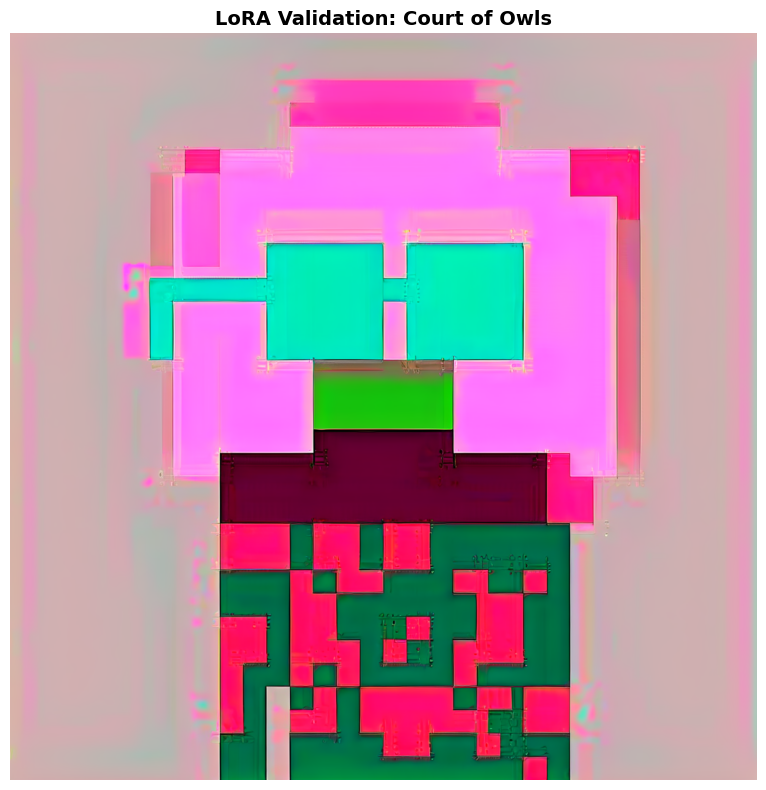

Images saved to: /kaggle/working/output/validation_results.png


In [8]:
import torch
from diffusers import DiffusionPipeline
import matplotlib.pyplot as plt
import os

# 1. Load the base model
pipe = DiffusionPipeline.from_pretrained(
    "segmind/SSD-1B",
    torch_dtype=torch.float16,
    variant="fp16"
)
pipe.to("cuda")

# 2. Load your trained LoRA weights
# Ensure this path is correct based on your training output
lora_path = "/kaggle/working/court_of_owls_lora_plan_b/pytorch_lora_weights.safetensors"
if os.path.exists(lora_path):
    pipe.load_lora_weights(lora_path)
    print("LoRA weights loaded successfully.")
else:
    print("Warning: LoRA weights not found at the specified path!")

# 3. Your specific prompt
prompt = "a character with circular blue glasses, a square-shaped head and a teal-colored body on a cool background"

print(f"Generating image...")
# We remove the loop since you are doing a single specific test
generated_image = pipe(
    prompt=prompt,
    num_inference_steps=25,
    guidance_scale=7.5,
    generator=torch.Generator("cuda").manual_seed(42)
).images[0]

# 4. Display results (Single plot for one prompt)
plt.figure(figsize=(8, 8))
plt.imshow(generated_image)
plt.title("LoRA Validation: Court of Owls", fontsize=14, fontweight='bold')
plt.axis('off') 
plt.tight_layout()

# 5. Create output directory and save
# Note: Always save BEFORE calling plt.show()
os.makedirs("/kaggle/working/output", exist_ok=True)
save_path = "/kaggle/working/output/validation_results.png"
plt.savefig(save_path)
plt.show()

print(f"Images saved to: {save_path}")